## Neural network with 2 hidden layers for image classification (digit-recognition):
- using Relu as activation function
- using Softmax

In [162]:
from typing import Dict, Tuple, List
import numpy as np

###  Load MNIST Data from IDX Files
We load the handwritten digit images and labels from the raw IDX format using `idx2numpy`. The training set contains 60,000 images of size 28×28, and the test set contains 10,000.

In [163]:
import idx2numpy

# Training data
X_train = idx2numpy.convert_from_file("archive/train-images.idx3-ubyte")
y_train = idx2numpy.convert_from_file("archive/train-labels.idx1-ubyte")

# Test data
X_test = idx2numpy.convert_from_file("archive/t10k-images.idx3-ubyte")
y_test = idx2numpy.convert_from_file("archive/t10k-labels.idx1-ubyte")

print("X_train shape:", X_train.shape)  # Should be (60000, 28, 28)
print("y_train shape:", y_train.shape)  # Should be (60000,)


X_train shape: (60000, 28, 28)
y_train shape: (60000,)


###  Flatten and Normalize Data
We flatten each 28×28 image to a 784-length vector, normalize pixel values to [0, 1], and transpose the dataset so each column corresponds to one image sample.

In [164]:
# We want to flatten the shape (784, num_batches or samples) to [1,0]
X_train_flat = X_train.reshape(X_train.shape[0], -1).T / 255.0 # shape: (784, 60000)
X_test_flat =  X_test.reshape(X_test.shape[0], -1).T / 255.0 # shape: (784, 10000)

print(f"X_train_flat shape:{X_train_flat.shape}")
print(f"X_test_flat shape:{X_test_flat.shape}")
print(X_train.shape[0])


X_train_flat shape:(784, 60000)
X_test_flat shape:(784, 10000)
60000


### - Shuffle all 60_000 samples
### - Reverse the first 10% (6_000 samples)  for validation
### - Using the remaining 90% (54_000 samples) for training

In [165]:
m = X_train_flat.shape[1] # Total number of training examples
indices = np.random.permutation(m) #Shuffle indices
val_size = int(0.1 * m) # split point (10% for validation)

val_indices = indices[:val_size] # Get validation and training indices
train_indices = indices[val_size:]

# split of the data (val, train)
X_val_split = X_train_flat[:, val_indices]
y_val_split = y_train[val_indices]

X_train_split = X_train_flat[:, train_indices]
y_train_split = y_train[train_indices]


In [176]:
def initialize_parameters() -> Dict[str, np.ndarray]:
    np.random.seed(42)
    parameters: Dict[str, np.ndarray] = {
        "W1": np.random.randn(128, 784) * np.sqrt(2 / 784),
        "b1": np.zeros((128, 1)),
        "W2": np.random.randn(64, 128) * np.sqrt(2 / 128),
        "b2": np.zeros((64, 1)),
        "W3": np.random.randn(10, 64) * np.sqrt(2 / 64),
        "b3": np.zeros((10, 1))
    }
    return parameters

# A way to check your parameters initializations
params = initialize_parameters()
for k in params:
    print(f"{k}: {params[k].shape}")


W1: (128, 784)
b1: (128, 1)
W2: (64, 128)
b2: (64, 1)
W3: (10, 64)
b3: (10, 1)


In [167]:
# define the activation functions (ReLu + Softmax)
def relu(Z: np.ndarray)-> np.ndarray:
    return np.maximum(0,Z)

def softmax(Z: np.ndarray)-> np.ndarray:
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True)) # prevent overflow
    return expZ / np.sum(expZ, axis=0, keepdims=True)
    

In [168]:
# forward_pass
def forward_pass(X: np.ndarray, parameters: Dict[str, np.ndarray])-> Tuple[np.ndarray, Tuple]:

    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]
    
    Z1 = W1 @ X + b1
    A1 = relu(Z1)
    
    Z2 = W2 @ A1 + b2
    A2 = relu(Z2)
    
    Z3 = W3 @ A2 + b3
    A3 = softmax(Z3)
    
    cache = (Z1, A1, Z2, A2, Z3, A3)
    
    return A3, cache

###  Evaluate Accuracy on First Batch
We compute predictions using `argmax` on the softmax output and compare them to the true labels to calculate accuracy for the first mini-batch.

In [169]:
# test the forward pass on one batch
# initalize the parameters
parameters = initialize_parameters()

# get some batches = 32
X_batch = X_test_flat[:, :32]
true_labels = y_train[:32]

#Forward_pass
A3, cache = forward_pass(X_batch, parameters)

#Evaluation 
prediction = np.argmax(A3, axis=0)
accuracy = np.mean(prediction == true_labels)

print("Output probabilities shape:", A3.shape)  # (10, 32)
print(f"First prediction :{np.round(A3[:, 0], 3)}")
print(f"Accuracy on first batch: {accuracy * 100:.2f}%")


Output probabilities shape: (10, 32)
First prediction :[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy on first batch: 6.25%


# Loss Function(Cross-Entropy)
- I have chosen Cross-Entropy for my loss function becasue Softmax plus Cross entropy is easier to compute from scratch

In [170]:
def compute_loss(A3: np.ndarray, Y: np.ndarray)-> float:
    """
    Cross-entropy loss:
    - A3: predicted probabilities (10, m)
    - Y: one-hot true labels (10, m)
    """
    
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(A3 + 1e-8)) / m
    return loss
    

# One-Hot Encode Labels
- Before backprop, we make sure y_train in one-hot encoded()

In [171]:
def one_hot_encode(y :np.ndarray, num_classes: int = 10)-> np.ndarray:
    one_hot= np.zeros((num_classes, y.size))
    one_hot[y, np.arange(y.size)] = 1
    return one_hot


In [172]:
def backward_pass(X: np.ndarray, Y: np.ndarray, cache: Tuple, parameters: Dict[str, np.ndarray])-> Dict[str, np.ndarray]:
    """
    Backprop through the 3-layer NN using cached forward values.
    """
    W1, W2, W3 = parameters["W1"], parameters["W2"], parameters["W3"]
    Z1, A1, Z2, A2, Z3, A3 = cache
    m = X.shape[1]

    # Output layer gradient (Softmax + CrossEntropy simplifies)
    dZ3 = A3 - Y  # (10, m)
    dW3 = (1 / m) * dZ3 @ A2.T
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

    # Hidden Layer 2
    dA2 = W3.T @ dZ3
    dZ2 = dA2 * (Z2 > 0)  # ReLU backward
    dW2 = (1 / m) * dZ2 @ A1.T
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # Hidden Layer 1
    dA1 = W2.T @ dZ2
    dZ1 = dA1 * (Z1 > 0)  # ReLU backward
    dW1 = (1 / m) * dZ1 @ X.T
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {
        "dW1": dW1, "db1": db1,
        "dW2": dW2, "db2": db2,
        "dW3": dW3, "db3": db3
    }

    return grads


In [173]:
def update_parameters(parameters: Dict[str, np.ndarray], grads: Dict[str, np.ndarray], learning_rate: float=0.1)-> Dict[str, np.ndarray]:
    for key in parameters:
        parameters[key] -= learning_rate * grads["d" + key]
    return parameters


In [181]:
def shuffle_data(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    indices = np.random.permutation(X.shape[1])
    return X[:, indices], y[indices]

def get_batches(X: np.ndarray, y: np.ndarray, batch_size: int):
    for i in range(0, X.shape[1], batch_size):
        yield X[:, i:i+batch_size], y[i:i+batch_size]

def train_one_epoch(X_train: np.ndarray, y_train: np.ndarray, parameters: Dict[str, np.ndarray], learning_rate: float, batch_size: int) -> Tuple[float, float, Dict[str, np.ndarray]]:
    X_shuffled, y_shuffled = shuffle_data(X_train, y_train)
    total_loss = 0
    correct = 0
    batches = X_train.shape[1] // batch_size

    for X_batch, y_batch in get_batches(X_shuffled, y_shuffled, batch_size):
        breakpoint()
        Y_batch = one_hot_encode(y_batch)
        A3, cache = forward_pass(X_batch, parameters)
        loss = compute_loss(A3, Y_batch)
        total_loss += loss

        predictions = np.argmax(A3, axis=0)
        correct += np.sum(predictions == y_batch)

        grads = backward_pass(X_batch, Y_batch, cache, parameters)
        parameters = update_parameters(parameters, grads, learning_rate)

    avg_loss = total_loss / batches
    accuracy = correct / X_train.shape[1] * 100
    return avg_loss, accuracy, parameters

def evaluate_model(X: np.ndarray, y: np.ndarray, parameters: Dict[str, np.ndarray]) -> Tuple[float, float]:
    A3, _ = forward_pass(X, parameters)
    loss = compute_loss(A3, one_hot_encode(y))
    predictions = np.argmax(A3, axis=0)
    accuracy = np.mean(predictions == y) * 100
    return loss, accuracy

def train_model(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, parameters: Dict[str, np.ndarray], epochs: int, batch_size: int, learning_rate: float):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        breakpoint()
        train_loss, train_acc, parameters = train_one_epoch(X_train, y_train, parameters, learning_rate, batch_size)
        val_loss, val_acc = evaluate_model(X_val, y_val, parameters)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return parameters, train_losses, val_losses, val_accs


epochs, batch_size, learning_rate, parameters = 15, 64, 0.1, initialize_parameters()
parameters, trai_losses, val_losses, val_acc = train_model(X_train_split, 
                                                           y_train_split,
                                                           X_val_split,
                                                           y_val_split,
                                                           parameters,
                                                           epochs, 
                                                           batch_size, learning_rate)


Epoch 1/15 | Train Loss: 0.3358 | Train Acc: 90.25% | Val Loss: 0.2280 | Val Acc: 93.35%
Epoch 2/15 | Train Loss: 0.1590 | Train Acc: 95.38% | Val Loss: 0.1674 | Val Acc: 94.88%
Epoch 3/15 | Train Loss: 0.1171 | Train Acc: 96.57% | Val Loss: 0.1279 | Val Acc: 96.18%
Epoch 4/15 | Train Loss: 0.0931 | Train Acc: 97.29% | Val Loss: 0.1176 | Val Acc: 96.22%
Epoch 5/15 | Train Loss: 0.0747 | Train Acc: 97.80% | Val Loss: 0.1082 | Val Acc: 96.52%
Epoch 6/15 | Train Loss: 0.0635 | Train Acc: 98.15% | Val Loss: 0.0995 | Val Acc: 96.92%
Epoch 7/15 | Train Loss: 0.0539 | Train Acc: 98.42% | Val Loss: 0.0985 | Val Acc: 96.77%
Epoch 8/15 | Train Loss: 0.0454 | Train Acc: 98.68% | Val Loss: 0.0949 | Val Acc: 96.95%
Epoch 9/15 | Train Loss: 0.0385 | Train Acc: 98.88% | Val Loss: 0.0872 | Val Acc: 97.28%
Epoch 10/15 | Train Loss: 0.0321 | Train Acc: 99.09% | Val Loss: 0.1053 | Val Acc: 96.67%
Epoch 11/15 | Train Loss: 0.0278 | Train Acc: 99.23% | Val Loss: 0.0838 | Val Acc: 97.27%
Epoch 12/15 | Train

### Sample Digits from Dataset

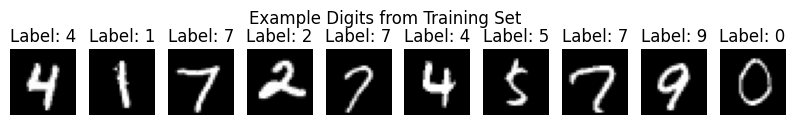

In [139]:
# Visualize 10 random samples from the training set
import matplotlib.pyplot as plt

num_samples = 10
indices = np.random.choice(X_train.shape[0], num_samples, replace=False)

plt.figure(figsize=(10, 1.5))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')
plt.suptitle("Example Digits from Training Set")
plt.show()


### Plot prediction before training

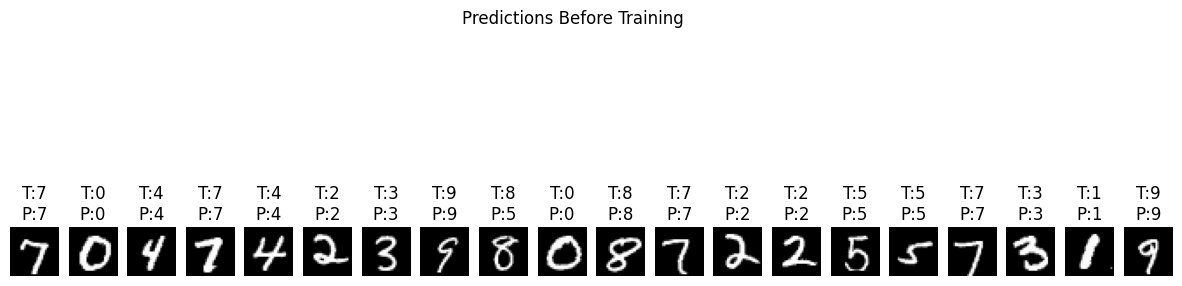

In [146]:
# Predictions before training (random network)
A3_pretrain, _ = forward_pass(X_val_split, parameters)
preds_pretrain = np.argmax(A3_pretrain, axis=0)

# Compare with true labels
sample_indices = np.random.choice(X_val_split.shape[1], 20, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    image = X_val_split[:, idx].reshape(28, 28)
    true_label = y_val_split[idx]
    predicted_label = preds_pretrain[idx]
    plt.subplot(1, 20, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"T:{true_label}\nP:{predicted_label}")
    plt.axis("off")
plt.suptitle("Predictions Before Training")
plt.show()


## We plot the Loss and Accuracy

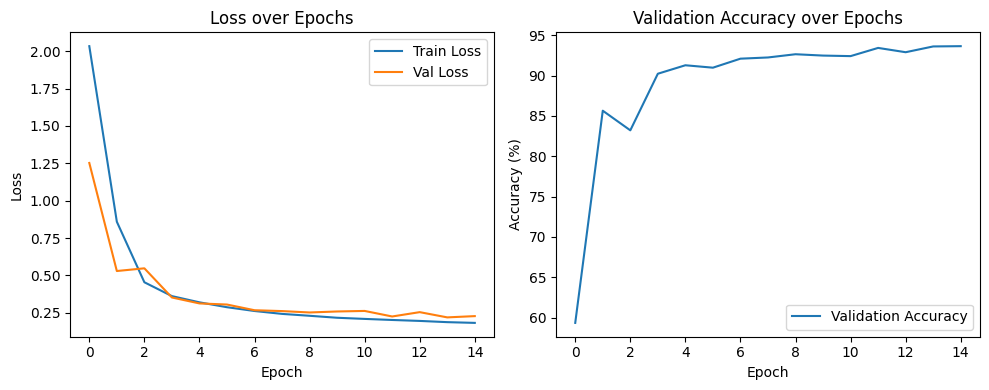

In [138]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(trai_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.tight_layout()
plt.show()


## Prediction after training 

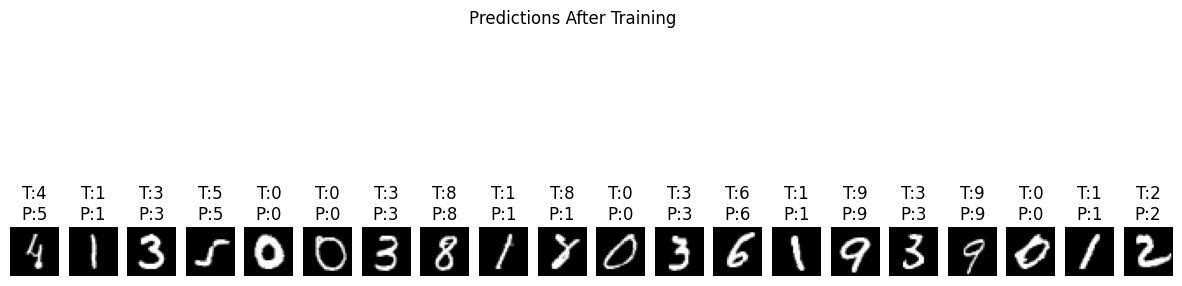

In [144]:
A3_post, _ = forward_pass(X_val_split, parameters)
preds_post = np.argmax(A3_post, axis=0)

# Show same style comparison after training
sample_indices = np.random.choice(X_val_split.shape[1], 20, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    image = X_val_split[:, idx].reshape(28, 28)
    true_label = y_val_split[idx]
    predicted_label = preds_post[idx]
    plt.subplot(1, 20, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"T:{true_label}\nP:{predicted_label}")
    plt.axis("off")
plt.suptitle("Predictions After Training")
plt.show()
